In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import os
import joblib
import gc
import warnings
import sys
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers
import math
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.tree import DecisionTreeClassifier
from joblib import parallel_backend
import dill
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import make_scorer
from imblearn.over_sampling import SMOTE
import pickle
from sklearn.metrics import confusion_matrix
sb.set()

In [4]:
time_1=pd.read_csv(r"1_3_5_8_9/Labelled_Files_Test/features/time_1.csv")
freq_1=pd.read_csv(r"1_3_5_8_9/Labelled_Files_Test/features/freq_1.csv")

combined_1 = pd.concat([time_1, freq_1], axis=1)
combined_1=combined_1[combined_1['0']!=2]
combined_1.dropna(inplace=True)
combined_1

,0,mean_A_F,max_A_F,min_A_F,var_A_F,std_A_F,rms_A_F,mav_A_F,zcr_A_F,p2p_A_F,...,spectral_kurtosis_T_F,bandpower_T_F,PSD_T_V,spectral_spread_T_V,spectral_kurtosis_T_V,bandpower_T_V,PSD_T_L,spectral_spread_T_L,spectral_kurtosis_T_L,bandpower_T_L
1,0,-173.968750,-161,-191,67.749023,8.230979,174.163357,173.968750,0.0,30,...,-1.279370,96.494643,88.051405,8.557427,-0.872340,89.489531,136.257608,9.806951,-1.097899,138.768663
2,0,-175.250000,-151,-202,88.531250,9.409105,175.502404,175.250000,0.0,51,...,-0.865323,56.195788,63.713318,7.871782,-0.394283,63.921791,74.847254,9.314909,-0.680520,75.500136
3,0,-163.968750,-141,-181,89.624023,9.466997,164.241819,163.968750,0.0,40,...,5.093917,344.585264,65.109948,9.225050,-1.171882,66.581253,218.366460,9.725060,-0.927582,225.153998
4,0,-160.375000,-141,-191,118.359375,10.879309,160.743585,160.375000,0.0,50,...,13.650000,633.804876,64.618683,8.919283,-0.940924,63.942849,218.073292,8.902031,0.603874,216.260808
5,0,-180.484375,-161,-202,138.593506,11.772574,180.867916,180.484375,0.0,41,...,5.606094,491.672603,144.043261,9.642371,-1.334032,141.936111,265.252185,7.097721,1.180612,271.647464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9185,1,79.734375,1040,-1010,46615.226318,215.905596,230.158200,137.015625,7.5,2050,...,3.314342,10636.646363,13458.929199,7.666057,0.646355,13279.468369,4693.095945,8.241055,2.220484,4545.136553
9186,1,80.796875,575,-505,25858.318115,160.805218,179.962366,135.953125,4.0,1080,...,9.749269,6551.998413,4813.087801,5.625249,3.857585,4950.174464,5675.247313,10.149863,-0.362134,5609.410490
9187,1,191.671875,1010,-828,96278.407959,310.287621,364.714293,277.671875,8.0,1838,...,21.375321,49319.739171,19045.847026,4.241639,2.853981,18826.461026,7200.020385,7.717877,0.305171,7450.732579
9188,1,223.484375,2929,-1212,552690.218506,743.431381,776.296003,427.453125,13.0,4141,...,24.027554,60586.894084,19985.025116,4.481814,8.753087,19957.000305,8021.491914,6.274847,2.071851,7714.673241


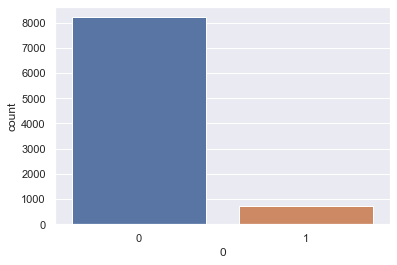

In [5]:
X = combined_1.drop('0', axis=1)
y = combined_1['0']

sb.countplot(data=pd.DataFrame(y), x='0')
plt.show()

In [6]:
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

In [7]:
scaler = StandardScaler()

X = scaler.fit_transform(X)

In [8]:
def getsize(model):
  p = pickle.dumps(model)
  return sys.getsizeof(p)

In [9]:
# Define custom function for specificity
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn+fp)
    return specificity

# Define a custom function that calculates the harmonic mean of sensitivity and specificity
def harmonic_mean(y_true, y_pred):
    sensitivity = recall_score(y_true, y_pred)
    specificity = specificity_score(y_true, y_pred)
    return 2 * (sensitivity * specificity) / (sensitivity + specificity)

# Create a custom scorer
custom_scorer = make_scorer(harmonic_mean, greater_is_better=True)

For Training Data:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0
Sensitivity: 1.0
Specificity: 1.0


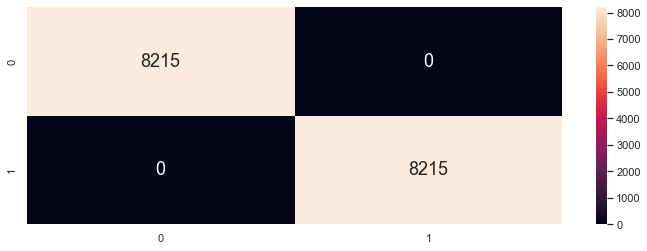

In [12]:
search = joblib.load(r"Models/Patient_1_3_5_8_9/dt_new_model_1.joblib")

rf_y_pred = search.predict(X)

tn, fp, fn, tp = confusion_matrix(y, rf_y_pred).ravel()

print("For Training Data:")
print('Accuracy:', accuracy_score(y, rf_y_pred))
print('Precision:', precision_score(y, rf_y_pred))
print('Recall:', recall_score(y, rf_y_pred))
print('F1-Score:', f1_score(y, rf_y_pred))

# Calculate Sensitivity
sensitivity = tp / (tp + fn)

# Calculate Specificity
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


f, axes = plt.subplots(1, 1, figsize=(12, 4))
sb.heatmap(confusion_matrix(y, rf_y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

For Training Data:
Accuracy: 0.822829131652661
Precision: 0.8994800693240901
Recall: 0.726890756302521
F1-Score: 0.8040278853601858
Sensitivity: 0.726890756302521
Specificity: 0.9187675070028011


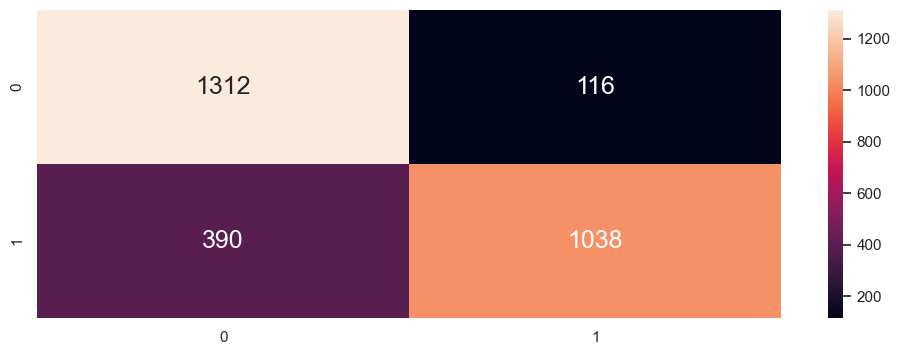

In [24]:
search = joblib.load(r"C:\Users\Admin\Desktop\Models\Patient_9\lgm_new_model_1.joblib")

rf_y_pred = search.predict(X)

tn, fp, fn, tp = confusion_matrix(y, rf_y_pred).ravel()

print("For Training Data:")
print('Accuracy:', accuracy_score(y, rf_y_pred))
print('Precision:', precision_score(y, rf_y_pred))
print('Recall:', recall_score(y, rf_y_pred))
print('F1-Score:', f1_score(y, rf_y_pred))

# Calculate Sensitivity
sensitivity = tp / (tp + fn)

# Calculate Specificity
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


f, axes = plt.subplots(1, 1, figsize=(12, 4))
sb.heatmap(confusion_matrix(y, rf_y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

For Training Data:
Accuracy: 0.8977591036414566
Precision: 0.9375963020030816
Recall: 0.8522408963585434
F1-Score: 0.8928833455612618
Sensitivity: 0.8522408963585434
Specificity: 0.9432773109243697


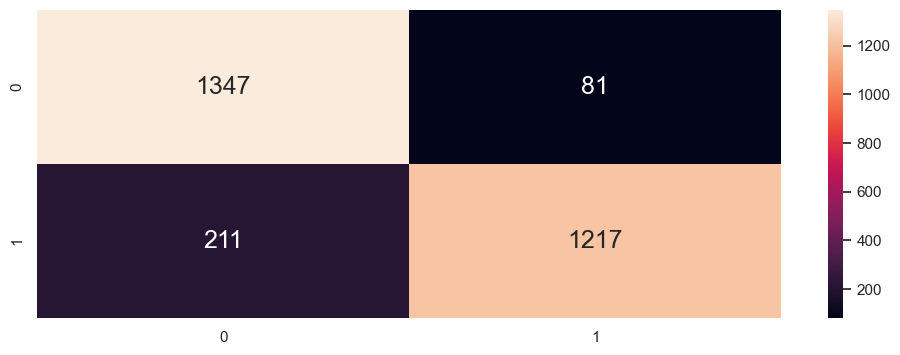

In [25]:
search = joblib.load(r"C:\Users\Admin\Desktop\Models\Patient_9\xgb_new_model.joblib")

rf_y_pred = search.predict(X)

tn, fp, fn, tp = confusion_matrix(y, rf_y_pred).ravel()

print("For Training Data:")
print('Accuracy:', accuracy_score(y, rf_y_pred))
print('Precision:', precision_score(y, rf_y_pred))
print('Recall:', recall_score(y, rf_y_pred))
print('F1-Score:', f1_score(y, rf_y_pred))

# Calculate Sensitivity
sensitivity = tp / (tp + fn)

# Calculate Specificity
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


f, axes = plt.subplots(1, 1, figsize=(12, 4))
sb.heatmap(confusion_matrix(y, rf_y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

For Training Data:
Accuracy: 0.5756302521008403
Precision: 0.8439490445859873
Recall: 0.18557422969187676
F1-Score: 0.30424799081515497
Sensitivity: 0.18557422969187676
Specificity: 0.9656862745098039


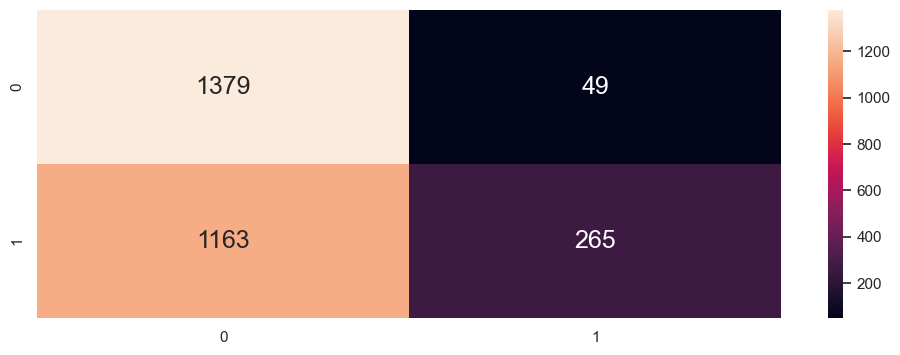

In [26]:
search = joblib.load(r"C:\Users\Admin\Desktop\Models\Patient_9\ada_new_model.joblib")

rf_y_pred = search.predict(X)

tn, fp, fn, tp = confusion_matrix(y, rf_y_pred).ravel()

print("For Training Data:")
print('Accuracy:', accuracy_score(y, rf_y_pred))
print('Precision:', precision_score(y, rf_y_pred))
print('Recall:', recall_score(y, rf_y_pred))
print('F1-Score:', f1_score(y, rf_y_pred))

# Calculate Sensitivity
sensitivity = tp / (tp + fn)

# Calculate Specificity
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


f, axes = plt.subplots(1, 1, figsize=(12, 4))
sb.heatmap(confusion_matrix(y, rf_y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

For Training Data:
Accuracy: 0.8837535014005602
Precision: 0.8663101604278075
Recall: 0.907563025210084
F1-Score: 0.8864569083447332
Sensitivity: 0.907563025210084
Specificity: 0.8599439775910365


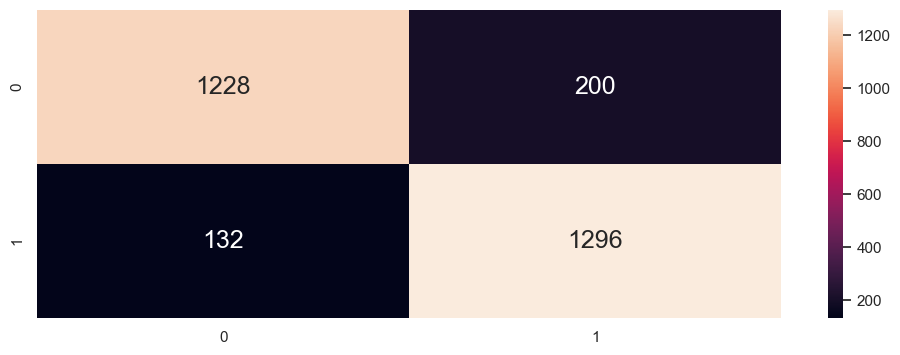

In [27]:
search = joblib.load(r"C:\Users\Admin\Desktop\Models\Patient_9\knn_new_model.joblib")

rf_y_pred = search.predict(X)

tn, fp, fn, tp = confusion_matrix(y, rf_y_pred).ravel()

print("For Training Data:")
print('Accuracy:', accuracy_score(y, rf_y_pred))
print('Precision:', precision_score(y, rf_y_pred))
print('Recall:', recall_score(y, rf_y_pred))
print('F1-Score:', f1_score(y, rf_y_pred))

# Calculate Sensitivity
sensitivity = tp / (tp + fn)

# Calculate Specificity
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


f, axes = plt.subplots(1, 1, figsize=(12, 4))
sb.heatmap(confusion_matrix(y, rf_y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

In [28]:
time_2=pd.read_csv(r"C:\Users\Admin\Desktop\Labelled_Files_1\features\time_2.csv")
freq_2=pd.read_csv(r"C:\Users\Admin\Desktop\Labelled_Files_1\features\freq_2.csv")

combined_2 = pd.concat([time_2, freq_2], axis=1)
combined_2=combined_2[combined_2['0']!=2]
combined_2.dropna(inplace=True)
combined_2

,0,mean_A_F,max_A_F,min_A_F,var_A_F,std_A_F,rms_A_F,mav_A_F,zcr_A_F,p2p_A_F,...,spectral_kurtosis_T_F,bandpower_T_F,PSD_T_V,spectral_spread_T_V,spectral_kurtosis_T_V,bandpower_T_V,PSD_T_L,spectral_spread_T_L,spectral_kurtosis_T_L,bandpower_T_L
1,0,78.601562,1030,-828,60655.739685,246.283860,258.522621,156.617188,3.5,1858,...,12.439837,8560.738025,15983.535370,4.248273,2.370674,7979.675602,4755.142983,7.571073,0.379642,2399.398173
2,0,156.140625,1838,-2292,401451.667725,633.602137,652.557708,413.609375,9.0,4130,...,6.373211,6877.955426,18266.900303,4.884802,0.837604,8786.549459,5069.140897,5.838538,1.651229,2713.047835
3,0,85.671875,1616,-969,179734.798584,423.951411,432.521062,260.796875,9.0,2585,...,6.841925,11944.926833,40588.163377,4.587193,2.647984,20789.235206,14451.020219,6.734947,0.462077,7376.805080
4,0,221.210938,2121,-2020,385493.213318,620.880998,659.111138,387.492188,7.5,4141,...,9.759224,8079.526761,24040.578673,4.565041,3.028936,12640.882407,6065.831452,5.945447,1.705845,3031.083371
5,0,155.703125,1919,-1808,331288.989990,575.577093,596.265422,357.250000,9.5,3727,...,5.507809,11090.339744,26213.642146,7.035668,0.306370,13292.952872,9531.289506,7.223921,2.797861,4819.899494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1666,1,206.671875,2959,-393,109801.861084,331.363639,390.531849,244.609375,3.0,3352,...,3.685523,4605.687116,11879.681329,5.380899,3.137411,6266.845412,5480.937963,8.388439,0.459242,2791.476408
1667,1,219.843750,3212,-353,86467.006836,294.052728,367.148854,245.046875,3.0,3565,...,6.387700,4223.543442,13826.200372,4.706745,3.260161,6686.544807,6030.638460,7.772561,0.243918,3158.263231
1668,1,288.445312,2848,-1181,315804.122009,561.964520,631.668283,399.164062,5.0,4029,...,3.152466,8398.438118,26427.903535,6.707569,0.318474,12959.945923,7732.347773,8.024593,-0.156369,3944.828710
1669,1,387.890625,4111,-1757,776518.003662,881.202589,962.796521,590.093750,8.0,5868,...,9.044716,6584.775160,13789.042777,5.084150,2.497281,6695.225971,8667.012826,7.872043,-0.653135,4277.529343


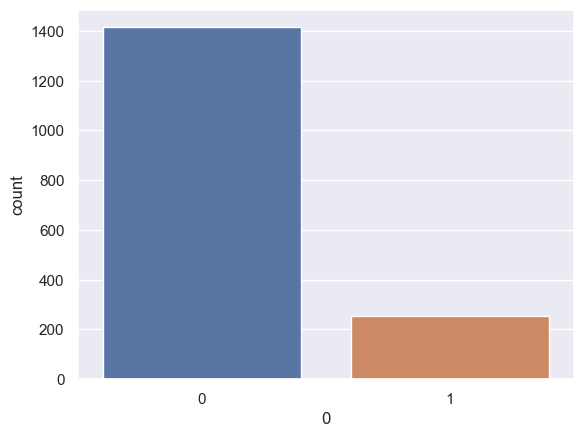

In [29]:
X = combined_2.drop('0', axis=1)
y = combined_2['0']

sb.countplot(data=pd.DataFrame(y), x='0')
plt.show()

In [30]:
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

In [31]:
scaler = StandardScaler()

X = scaler.fit_transform(X)

For Training Data:
Accuracy: 0.8275618374558303
Precision: 0.897172236503856
Recall: 0.7399293286219081
F1-Score: 0.8109992254066615
Sensitivity: 0.7399293286219081
Specificity: 0.9151943462897526


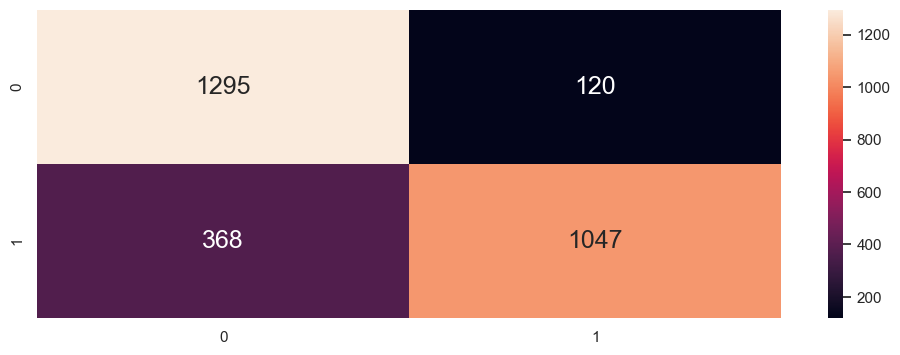

In [32]:
search = joblib.load(r"C:\Users\Admin\Desktop\Models\Patient_9\dt_new_model.joblib")

rf_y_pred = search.predict(X)

tn, fp, fn, tp = confusion_matrix(y, rf_y_pred).ravel()

print("For Training Data:")
print('Accuracy:', accuracy_score(y, rf_y_pred))
print('Precision:', precision_score(y, rf_y_pred))
print('Recall:', recall_score(y, rf_y_pred))
print('F1-Score:', f1_score(y, rf_y_pred))

# Calculate Sensitivity
sensitivity = tp / (tp + fn)

# Calculate Specificity
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


f, axes = plt.subplots(1, 1, figsize=(12, 4))
sb.heatmap(confusion_matrix(y, rf_y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

For Training Data:
Accuracy: 0.7660777385159011
Precision: 0.8724035608308606
Recall: 0.623321554770318
F1-Score: 0.7271228359439407
Sensitivity: 0.623321554770318
Specificity: 0.9088339222614841


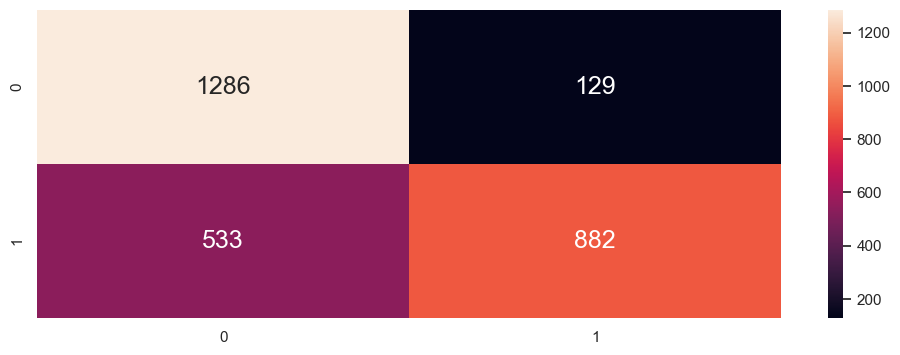

In [33]:
search = joblib.load(r"C:\Users\Admin\Desktop\Models\Patient_9\lgm_new_model.joblib")

rf_y_pred = search.predict(X)

tn, fp, fn, tp = confusion_matrix(y, rf_y_pred).ravel()

print("For Training Data:")
print('Accuracy:', accuracy_score(y, rf_y_pred))
print('Precision:', precision_score(y, rf_y_pred))
print('Recall:', recall_score(y, rf_y_pred))
print('F1-Score:', f1_score(y, rf_y_pred))

# Calculate Sensitivity
sensitivity = tp / (tp + fn)

# Calculate Specificity
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


f, axes = plt.subplots(1, 1, figsize=(12, 4))
sb.heatmap(confusion_matrix(y, rf_y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

For Training Data:
Accuracy: 0.9201413427561838
Precision: 0.9237348538845331
Recall: 0.9159010600706714
F1-Score: 0.9198012775017743
Sensitivity: 0.9159010600706714
Specificity: 0.9243816254416961


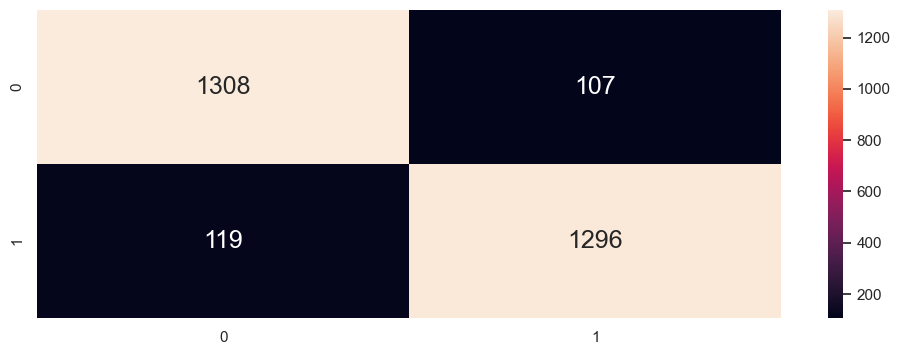

In [34]:
search = joblib.load(r"C:\Users\Admin\Desktop\Models\Patient_9\xgb_new_model.joblib")

rf_y_pred = search.predict(X)

tn, fp, fn, tp = confusion_matrix(y, rf_y_pred).ravel()

print("For Training Data:")
print('Accuracy:', accuracy_score(y, rf_y_pred))
print('Precision:', precision_score(y, rf_y_pred))
print('Recall:', recall_score(y, rf_y_pred))
print('F1-Score:', f1_score(y, rf_y_pred))

# Calculate Sensitivity
sensitivity = tp / (tp + fn)

# Calculate Specificity
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


f, axes = plt.subplots(1, 1, figsize=(12, 4))
sb.heatmap(confusion_matrix(y, rf_y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

For Training Data:
Accuracy: 0.5869257950530036
Precision: 0.7733333333333333
Recall: 0.24593639575971732
F1-Score: 0.37319034852546923
Sensitivity: 0.24593639575971732
Specificity: 0.9279151943462898


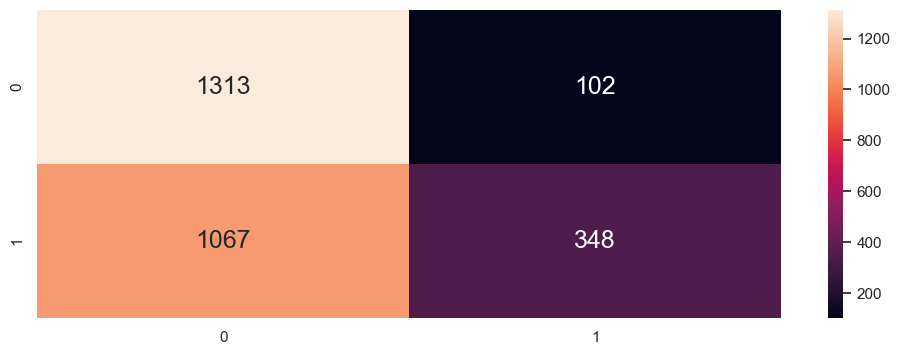

In [35]:
search = joblib.load(r"C:\Users\Admin\Desktop\Models\Patient_9\ada_new_model.joblib")

rf_y_pred = search.predict(X)

tn, fp, fn, tp = confusion_matrix(y, rf_y_pred).ravel()

print("For Training Data:")
print('Accuracy:', accuracy_score(y, rf_y_pred))
print('Precision:', precision_score(y, rf_y_pred))
print('Recall:', recall_score(y, rf_y_pred))
print('F1-Score:', f1_score(y, rf_y_pred))

# Calculate Sensitivity
sensitivity = tp / (tp + fn)

# Calculate Specificity
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


f, axes = plt.subplots(1, 1, figsize=(12, 4))
sb.heatmap(confusion_matrix(y, rf_y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

For Training Data:
Accuracy: 0.8830388692579505
Precision: 0.8465473145780051
Recall: 0.9356890459363958
F1-Score: 0.888888888888889
Sensitivity: 0.9356890459363958
Specificity: 0.8303886925795053


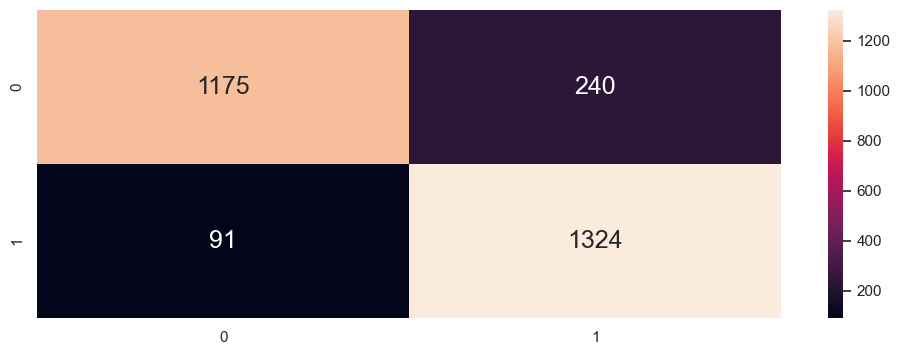

In [36]:
search = joblib.load(r"C:\Users\Admin\Desktop\Models\Patient_9\knn_new_model.joblib")

rf_y_pred = search.predict(X)

tn, fp, fn, tp = confusion_matrix(y, rf_y_pred).ravel()

print("For Training Data:")
print('Accuracy:', accuracy_score(y, rf_y_pred))
print('Precision:', precision_score(y, rf_y_pred))
print('Recall:', recall_score(y, rf_y_pred))
print('F1-Score:', f1_score(y, rf_y_pred))

# Calculate Sensitivity
sensitivity = tp / (tp + fn)

# Calculate Specificity
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


f, axes = plt.subplots(1, 1, figsize=(12, 4))
sb.heatmap(confusion_matrix(y, rf_y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

In [37]:
time_3=pd.read_csv(r"C:\Users\Admin\Desktop\Labelled_Files_1\features\time_3.csv")
freq_3=pd.read_csv(r"C:\Users\Admin\Desktop\Labelled_Files_1\features\freq_3.csv")

combined_3 = pd.concat([time_3, freq_3], axis=1)
combined_3=combined_3[combined_3['0']!=2]
combined_3.dropna(inplace=True)
combined_3

,0,mean_A_F,max_A_F,min_A_F,var_A_F,std_A_F,rms_A_F,mav_A_F,zcr_A_F,p2p_A_F,...,spectral_kurtosis_T_F,bandpower_T_F,PSD_T_V,spectral_spread_T_V,spectral_kurtosis_T_V,bandpower_T_V,PSD_T_L,spectral_spread_T_L,spectral_kurtosis_T_L,bandpower_T_L
1,0,153.421875,1838,-2292,294653.587646,542.820032,564.084975,342.932292,12.5,4130,...,7.593522,10234.580155,40685.734815,5.122134,0.313456,13901.612892,10678.559553,6.244251,0.671149,3514.327963
2,0,131.567708,1939,-2020,238000.755832,487.853211,505.282909,292.234375,11.5,3959,...,6.028521,11148.230597,50536.036654,5.117607,1.699729,17126.770403,19664.364358,6.102997,1.372306,6650.968936
3,0,176.822917,2121,-1808,364779.114475,603.969465,629.321427,378.125000,14.5,3929,...,6.219703,9242.944073,36430.916995,6.523793,1.015550,12478.855363,13280.903092,6.447769,2.924348,4552.875957
4,0,140.838542,1565,-1696,172971.947890,415.898964,439.098443,262.505208,13.5,3261,...,3.127784,10868.017239,53571.436884,4.308446,2.863834,18632.071242,14799.042561,6.218893,2.455263,5130.157469
5,0,177.104167,1636,-1202,250726.270399,500.725744,531.123485,326.281250,13.0,2838,...,3.418140,11031.648049,59213.963083,6.033918,0.820188,20139.359784,13201.531524,7.895909,0.864310,4562.738818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1652,1,304.515625,3242,-1959,248723.593506,498.721960,584.340106,389.026042,7.0,5201,...,12.734295,9452.854812,45025.510099,3.506367,8.063045,14499.439996,6454.537073,7.817407,0.361118,2170.316094
1653,1,213.895833,4000,-2151,251584.249566,501.581748,545.284950,298.302083,7.0,6151,...,9.578940,6843.040113,26953.433332,4.713681,5.602882,8675.493318,13008.823381,7.128794,1.190938,4309.503888
1654,1,210.177083,2959,-393,77490.041558,278.370332,348.804312,240.510417,4.0,3352,...,4.031755,4481.440818,24483.440498,5.088661,6.001118,8034.023519,15639.764744,8.952849,-0.832875,5171.982215
1655,1,266.463542,3212,-1181,264878.217421,514.663208,579.552445,352.036458,7.0,4393,...,3.898603,9182.877798,37472.024200,6.563156,0.425355,12313.225141,13327.581607,7.727615,0.430103,4383.276871


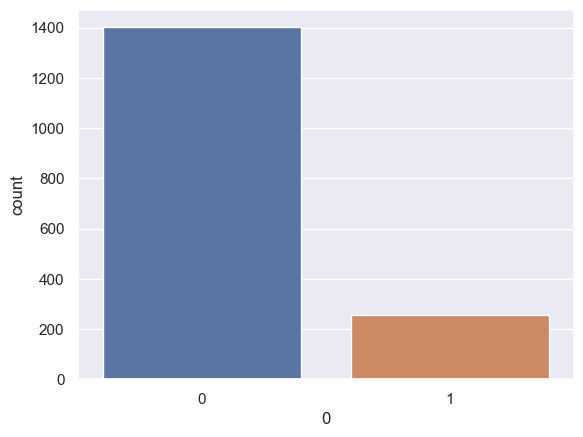

In [38]:
X = combined_3.drop('0', axis=1)
y = combined_3['0']

sb.countplot(data=pd.DataFrame(y), x='0')
plt.show()

In [39]:
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

In [40]:
scaler = StandardScaler()

X = scaler.fit_transform(X)

For Training Data:
Accuracy: 0.8315488936473947
Precision: 0.8900083963056256
Recall: 0.7566024268379729
F1-Score: 0.8179012345679011
Sensitivity: 0.7566024268379729
Specificity: 0.9064953604568166


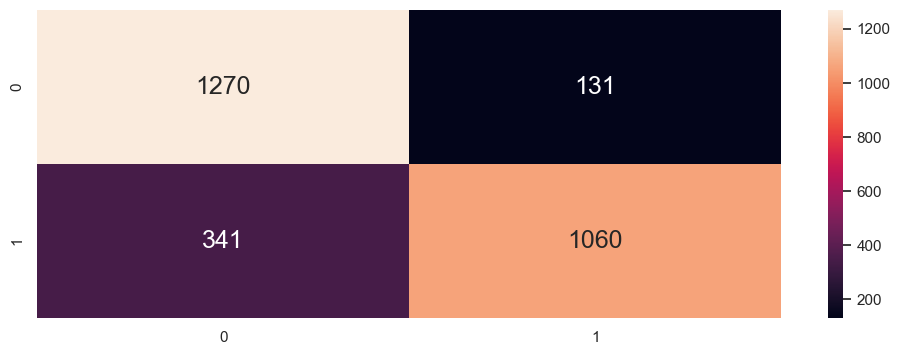

In [41]:
search = joblib.load(r"C:\Users\Admin\Desktop\Models\Patient_9\dt_new_model.joblib")

rf_y_pred = search.predict(X)

tn, fp, fn, tp = confusion_matrix(y, rf_y_pred).ravel()

print("For Training Data:")
print('Accuracy:', accuracy_score(y, rf_y_pred))
print('Precision:', precision_score(y, rf_y_pred))
print('Recall:', recall_score(y, rf_y_pred))
print('F1-Score:', f1_score(y, rf_y_pred))

# Calculate Sensitivity
sensitivity = tp / (tp + fn)

# Calculate Specificity
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


f, axes = plt.subplots(1, 1, figsize=(12, 4))
sb.heatmap(confusion_matrix(y, rf_y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

For Training Data:
Accuracy: 0.7612419700214133
Precision: 0.8465909090909091
Recall: 0.6381156316916489
F1-Score: 0.7277167277167278
Sensitivity: 0.6381156316916489
Specificity: 0.8843683083511777


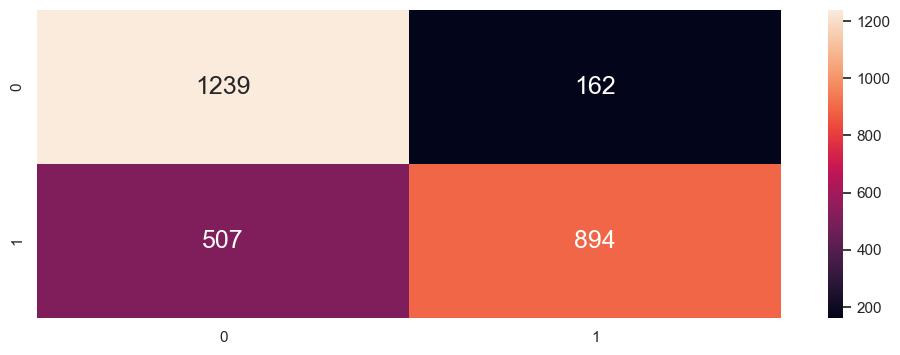

In [42]:
search = joblib.load(r"C:\Users\Admin\Desktop\Models\Patient_9\lgm_new_model.joblib")

rf_y_pred = search.predict(X)

tn, fp, fn, tp = confusion_matrix(y, rf_y_pred).ravel()

print("For Training Data:")
print('Accuracy:', accuracy_score(y, rf_y_pred))
print('Precision:', precision_score(y, rf_y_pred))
print('Recall:', recall_score(y, rf_y_pred))
print('F1-Score:', f1_score(y, rf_y_pred))

# Calculate Sensitivity
sensitivity = tp / (tp + fn)

# Calculate Specificity
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


f, axes = plt.subplots(1, 1, figsize=(12, 4))
sb.heatmap(confusion_matrix(y, rf_y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

For Training Data:
Accuracy: 0.9114917915774446
Precision: 0.8940533151059467
Recall: 0.9336188436830836
F1-Score: 0.9134078212290503
Sensitivity: 0.9336188436830836
Specificity: 0.8893647394718058


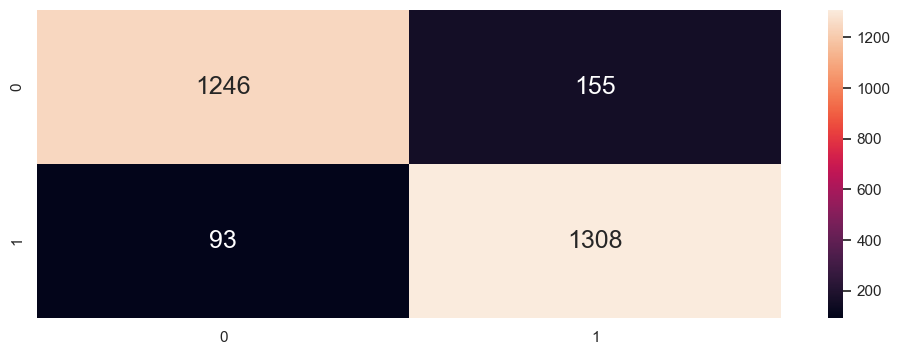

In [44]:
search = joblib.load(r"C:\Users\Admin\Desktop\Models\Patient_9\xgb_new_model.joblib")

rf_y_pred = search.predict(X)

tn, fp, fn, tp = confusion_matrix(y, rf_y_pred).ravel()

print("For Training Data:")
print('Accuracy:', accuracy_score(y, rf_y_pred))
print('Precision:', precision_score(y, rf_y_pred))
print('Recall:', recall_score(y, rf_y_pred))
print('F1-Score:', f1_score(y, rf_y_pred))

# Calculate Sensitivity
sensitivity = tp / (tp + fn)

# Calculate Specificity
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


f, axes = plt.subplots(1, 1, figsize=(12, 4))
sb.heatmap(confusion_matrix(y, rf_y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

For Training Data:
Accuracy: 0.588865096359743
Precision: 0.77728285077951
Recall: 0.2491077801570307
F1-Score: 0.3772972972972973
Sensitivity: 0.2491077801570307
Specificity: 0.9286224125624554


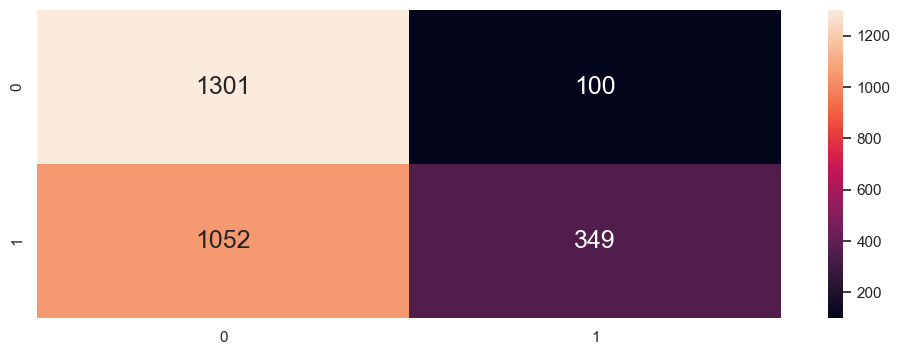

In [45]:
search = joblib.load(r"C:\Users\Admin\Desktop\Models\Patient_9\ada_new_model.joblib")

rf_y_pred = search.predict(X)

tn, fp, fn, tp = confusion_matrix(y, rf_y_pred).ravel()

print("For Training Data:")
print('Accuracy:', accuracy_score(y, rf_y_pred))
print('Precision:', precision_score(y, rf_y_pred))
print('Recall:', recall_score(y, rf_y_pred))
print('F1-Score:', f1_score(y, rf_y_pred))

# Calculate Sensitivity
sensitivity = tp / (tp + fn)

# Calculate Specificity
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


f, axes = plt.subplots(1, 1, figsize=(12, 4))
sb.heatmap(confusion_matrix(y, rf_y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

For Training Data:
Accuracy: 0.8807994289793005
Precision: 0.8340638697557922
Recall: 0.9507494646680942
F1-Score: 0.8885923949299533
Sensitivity: 0.9507494646680942
Specificity: 0.8108493932905068


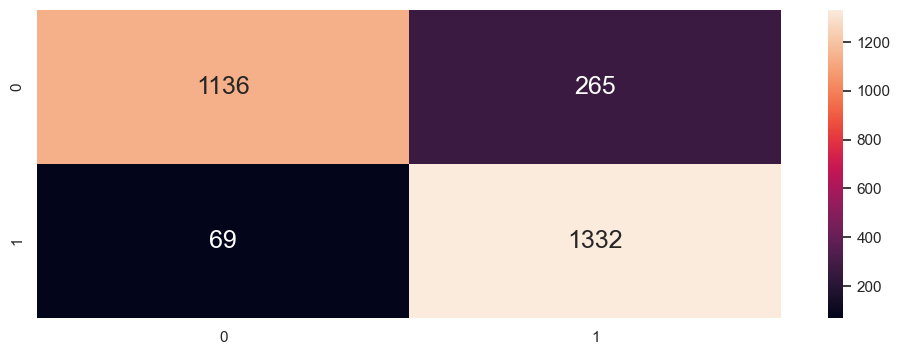

In [46]:
search = joblib.load(r"C:\Users\Admin\Desktop\Models\Patient_9\knn_new_model.joblib")

rf_y_pred = search.predict(X)

tn, fp, fn, tp = confusion_matrix(y, rf_y_pred).ravel()

print("For Training Data:")
print('Accuracy:', accuracy_score(y, rf_y_pred))
print('Precision:', precision_score(y, rf_y_pred))
print('Recall:', recall_score(y, rf_y_pred))
print('F1-Score:', f1_score(y, rf_y_pred))

# Calculate Sensitivity
sensitivity = tp / (tp + fn)

# Calculate Specificity
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


f, axes = plt.subplots(1, 1, figsize=(12, 4))
sb.heatmap(confusion_matrix(y, rf_y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

In [47]:
time_4=pd.read_csv(r"C:\Users\Admin\Desktop\Labelled_Files_1\features\time_4.csv")
freq_4=pd.read_csv(r"C:\Users\Admin\Desktop\Labelled_Files_1\features\freq_4.csv")

combined_4 = pd.concat([time_4, freq_4], axis=1)
combined_4=combined_4[combined_4['0']!=2]
combined_4.dropna(inplace=True)
combined_4

,0,mean_A_F,max_A_F,min_A_F,var_A_F,std_A_F,rms_A_F,mav_A_F,zcr_A_F,p2p_A_F,...,spectral_kurtosis_T_F,bandpower_T_F,PSD_T_V,spectral_spread_T_V,spectral_kurtosis_T_V,bandpower_T_V,PSD_T_L,spectral_spread_T_L,spectral_kurtosis_T_L,bandpower_T_L
1,0,120.906250,1838,-2292,291834.694336,540.217266,553.581986,337.203125,18.5,4130,...,7.501210,8154.744541,101289.710795,5.281374,6.529136,25214.915225,18702.184602,6.600194,1.903422,4702.477638
2,0,188.457031,2121,-2020,359463.920029,599.553100,628.474321,372.371094,17.0,4141,...,7.494167,9992.756274,55733.369784,5.854571,1.957940,14019.490113,17074.073519,5.982111,2.211674,4337.079846
3,0,147.480469,1616,-1696,208103.585556,456.183719,479.430990,286.253906,18.5,3312,...,1.890379,11496.264228,82881.245274,4.913145,1.786722,21111.611434,19348.280907,6.134125,3.218796,4915.459952
4,0,154.421875,1878,-1525,220338.689209,469.402481,494.150589,294.757812,18.0,3403,...,4.234824,8524.416190,79465.149176,5.483323,-0.144150,19923.993695,20244.662776,7.192268,0.914068,5164.974861
5,0,139.093750,2101,-1505,223587.772461,472.850687,492.884209,307.882812,21.0,3606,...,2.377008,5692.722553,65349.574485,5.074005,0.264429,16509.253363,22444.130120,5.419774,4.911356,5685.073783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1639,1,298.464844,5121,-2727,236366.748764,486.175636,570.480509,371.621094,7.0,7848,...,12.899149,9280.003708,31985.702006,5.254689,8.707404,7830.178765,25699.879390,8.349953,1.682462,6467.891804
1640,1,254.277344,4000,-2151,355181.731674,595.971251,647.949612,369.550781,12.0,6151,...,2.126747,17748.074927,89505.457172,6.642256,0.000306,22825.038150,25999.386614,7.249120,-0.389851,6538.394095
1641,1,211.558594,2959,-393,78557.512192,280.281131,351.161716,245.722656,6.0,3352,...,4.813419,6619.268869,30936.086183,5.343889,3.800282,7649.997555,14761.723918,9.111799,-0.516365,3784.680827
1642,1,293.226562,3616,-1757,363402.393982,602.828661,670.361254,403.617188,11.0,5373,...,4.869626,9184.895258,45343.590604,6.459832,0.652539,11216.975426,16089.336980,7.867869,-0.064450,4049.314648


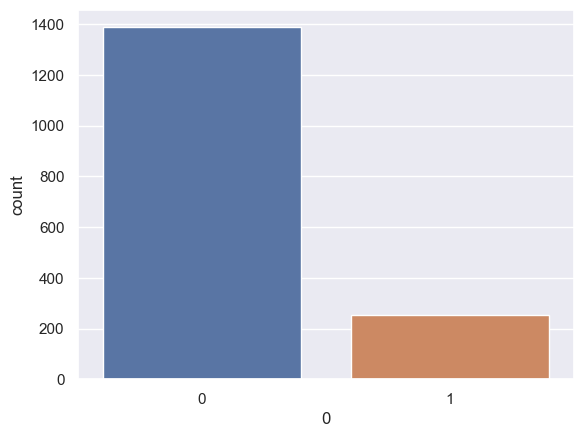

In [48]:
X = combined_4.drop('0', axis=1)
y = combined_4['0']

sb.countplot(data=pd.DataFrame(y), x='0')
plt.show()

In [49]:
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

In [50]:
scaler = StandardScaler()

X = scaler.fit_transform(X)

For Training Data:
Accuracy: 0.8137608069164265
Precision: 0.8857395925597874
Recall: 0.7204610951008645
F1-Score: 0.7945967421533572
Sensitivity: 0.7204610951008645
Specificity: 0.9070605187319885


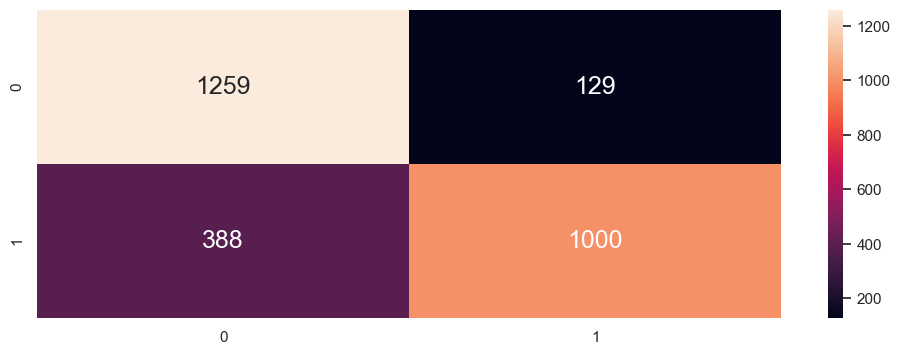

In [51]:
search = joblib.load(r"C:\Users\Admin\Desktop\Models\Patient_9\dt_new_model.joblib")

rf_y_pred = search.predict(X)

tn, fp, fn, tp = confusion_matrix(y, rf_y_pred).ravel()

print("For Training Data:")
print('Accuracy:', accuracy_score(y, rf_y_pred))
print('Precision:', precision_score(y, rf_y_pred))
print('Recall:', recall_score(y, rf_y_pred))
print('F1-Score:', f1_score(y, rf_y_pred))

# Calculate Sensitivity
sensitivity = tp / (tp + fn)

# Calculate Specificity
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


f, axes = plt.subplots(1, 1, figsize=(12, 4))
sb.heatmap(confusion_matrix(y, rf_y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

For Training Data:
Accuracy: 0.7600864553314121
Precision: 0.8431558935361216
Recall: 0.6390489913544669
F1-Score: 0.7270491803278688
Sensitivity: 0.6390489913544669
Specificity: 0.8811239193083573


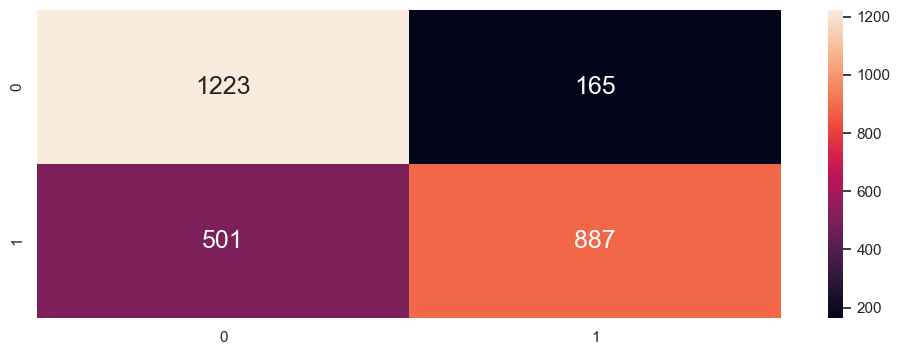

In [52]:
search = joblib.load(r"C:\Users\Admin\Desktop\Models\Patient_9\lgm_new_model.joblib")

rf_y_pred = search.predict(X)

tn, fp, fn, tp = confusion_matrix(y, rf_y_pred).ravel()

print("For Training Data:")
print('Accuracy:', accuracy_score(y, rf_y_pred))
print('Precision:', precision_score(y, rf_y_pred))
print('Recall:', recall_score(y, rf_y_pred))
print('F1-Score:', f1_score(y, rf_y_pred))

# Calculate Sensitivity
sensitivity = tp / (tp + fn)

# Calculate Specificity
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


f, axes = plt.subplots(1, 1, figsize=(12, 4))
sb.heatmap(confusion_matrix(y, rf_y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

For Training Data:
Accuracy: 0.9214697406340058
Precision: 0.8990450204638472
Recall: 0.9495677233429395
F1-Score: 0.9236159775753329
Sensitivity: 0.9495677233429395
Specificity: 0.8933717579250721


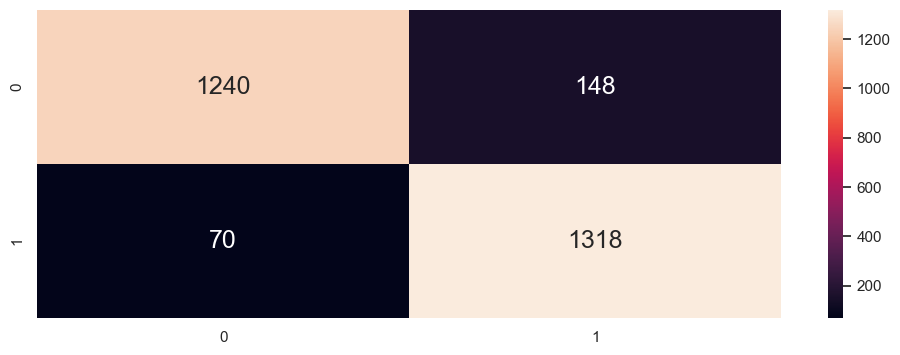

In [53]:
search = joblib.load(r"C:\Users\Admin\Desktop\Models\Patient_9\xgb_new_model.joblib")

rf_y_pred = search.predict(X)

tn, fp, fn, tp = confusion_matrix(y, rf_y_pred).ravel()

print("For Training Data:")
print('Accuracy:', accuracy_score(y, rf_y_pred))
print('Precision:', precision_score(y, rf_y_pred))
print('Recall:', recall_score(y, rf_y_pred))
print('F1-Score:', f1_score(y, rf_y_pred))

# Calculate Sensitivity
sensitivity = tp / (tp + fn)

# Calculate Specificity
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


f, axes = plt.subplots(1, 1, figsize=(12, 4))
sb.heatmap(confusion_matrix(y, rf_y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

For Training Data:
Accuracy: 0.6012247838616714
Precision: 0.7738791423001949
Recall: 0.28602305475504325
F1-Score: 0.4176749079431878
Sensitivity: 0.28602305475504325
Specificity: 0.9164265129682997


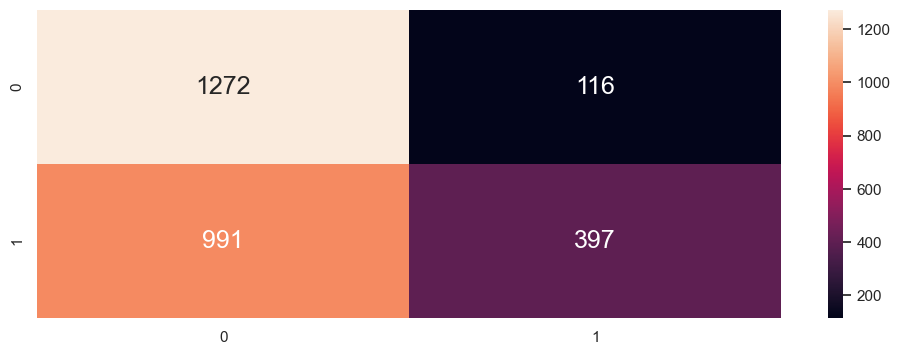

In [54]:
search = joblib.load(r"C:\Users\Admin\Desktop\Models\Patient_9\ada_new_model.joblib")

rf_y_pred = search.predict(X)

tn, fp, fn, tp = confusion_matrix(y, rf_y_pred).ravel()

print("For Training Data:")
print('Accuracy:', accuracy_score(y, rf_y_pred))
print('Precision:', precision_score(y, rf_y_pred))
print('Recall:', recall_score(y, rf_y_pred))
print('F1-Score:', f1_score(y, rf_y_pred))

# Calculate Sensitivity
sensitivity = tp / (tp + fn)

# Calculate Specificity
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


f, axes = plt.subplots(1, 1, figsize=(12, 4))
sb.heatmap(confusion_matrix(y, rf_y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

For Training Data:
Accuracy: 0.8901296829971181
Precision: 0.8504854368932039
Recall: 0.946685878962536
F1-Score: 0.8960109103307193
Sensitivity: 0.946685878962536
Specificity: 0.8335734870317003


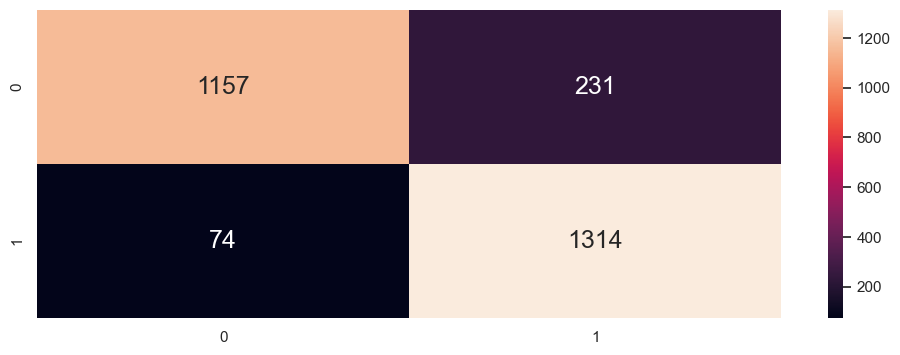

In [55]:
search = joblib.load(r"C:\Users\Admin\Desktop\Models\Patient_9\knn_new_model.joblib")

rf_y_pred = search.predict(X)

tn, fp, fn, tp = confusion_matrix(y, rf_y_pred).ravel()

print("For Training Data:")
print('Accuracy:', accuracy_score(y, rf_y_pred))
print('Precision:', precision_score(y, rf_y_pred))
print('Recall:', recall_score(y, rf_y_pred))
print('F1-Score:', f1_score(y, rf_y_pred))

# Calculate Sensitivity
sensitivity = tp / (tp + fn)

# Calculate Specificity
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


f, axes = plt.subplots(1, 1, figsize=(12, 4))
sb.heatmap(confusion_matrix(y, rf_y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()